# Primitive fitting

Surface $S$ with parameters $\theta$ and pointcloud $P$ of $n$ points.

Distance to surface is written $d(p_{i}, S(\theta))$.

Fitting aims to find the optimal set of parameters $\theta_{opt}$ that minimizes the sum of the squares of the distances also called the residual:
\begin{equation*}
res(\theta) = \sum^{n-1}_{i=0} d(p_{i}, S(\theta))^{2}
\end{equation*}


In [1]:
# Necessary imports
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize

sys.path.append("./utils")
from manip_utils import rotation_f_to_t

## Plane

### Plane parameters

| Parameter | Description |
|:----------|:------------|
| $c$       | center of the plane |
| $n$       | unit normal vector |
| $t$       | unit vector giving the length direction |
| $l$       | length of the plane |
| $w$       | width of the plane |

 

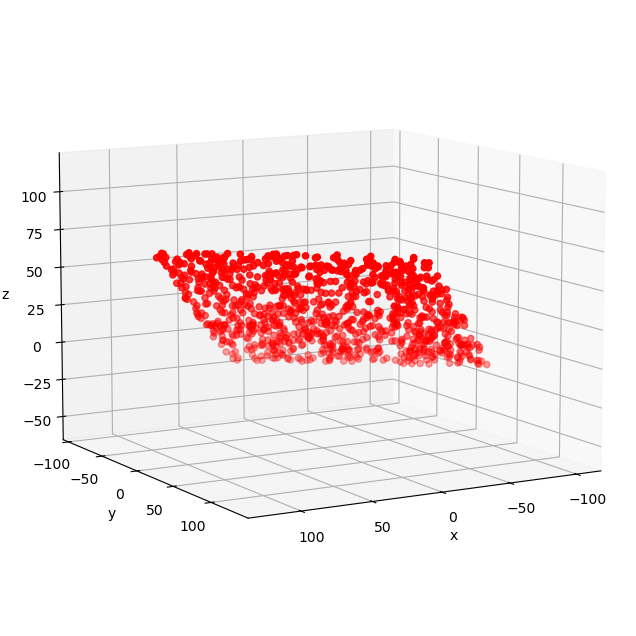

In [2]:
def generate_plane(center, normal, tangent, length, width, n=1000):

    # Start with a unit plane pointing towards z
    x = np.random.uniform(-.5, .5, (n, 1))
    y = np.random.uniform(-.5, .5, (n, 1))
    z = np.zeros((n, 1))
    points = np.hstack((x, y, z))
    # Adjust dimensions
    points[:, 0] *= length
    points[:, 1] *= width
    # Adjust orientation
    B = np.vstack([tangent, np.cross(normal, tangent), normal])
    P = np.linalg.inv(B)
    points = (B @ points.T).T
    # Adjust position
    return points + center


# Create a plane pointcloud
plane_center = np.array([10., 20., 30.])
plane_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
plane_tangent = np.array([np.sqrt(2)/2., np.sqrt(2)/2., 0.])
plane_length = 200.
plane_width = 125.
points_plane = generate_plane(plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_plane[:, 0], points_plane[:, 1], points_plane[:, 2],
           c="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()



### Point-to-plane distance

\begin{equation*}
d(p, P) = \sqrt{d_{n}^2 + \max(0, |d_{t}| - l/2)^2 + \max(0, |d_{b}| - w/2)^2}
\end{equation*}


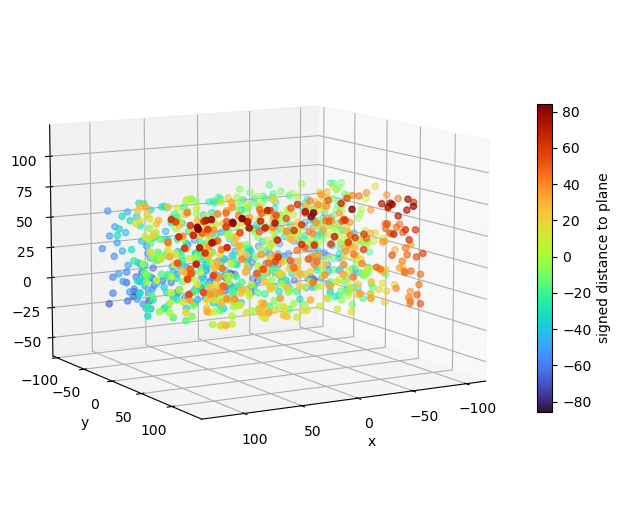

In [3]:
def dist_to_plane(points, center, normal, tangent=None, length=None, width=None):
    """Signed distance to the plane."""

    # Distance along the normal direction
    vec_to_center = points - center
    d_z = vec_to_center @ normal
    if tangent is None:
        return d_z
    # distance along the other dimensions (might be a finite or semi-infinite plane)
    d_x = vec_to_center @ tangent if length is not None else 0.
    d_y = vec_to_center @ np.cross(normal, tangent) if width is not None else 0.
    # Total distance
    d_xyz = np.sqrt(d_z**2 + (np.abs(d_x) - length/2).clip(0)**2 + (np.abs(d_y) - width/2).clip(0)**2)
    # Signed distance
    return np.sign(d_z) * d_xyz


# Try
random_points = np.random.uniform(points_plane.min(axis=0), points_plane.max(axis=0), (1000, 3))
dists_plane = dist_to_plane(random_points, plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_plane, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to plane')
plt.axis("equal")
plt.show()

    

### Least-squares plane

It admits a direct solution.


In [4]:
def fit_plane(points):

    # Center pointcloud
    centroid = points.mean(axis=0)
    X = points - centroid
    # Covariance matrix
    cov = X.T @ X
    # Eigen decomposition
    w, v = np.linalg.eigh(cov)
    # Sum of squared residuals is equal to the smallest eingen value
    res = w[0]
    # Nomal vector
    normal = v[:, 0]
    # Tangent vector (length direction)
    tangent = v[:, 2]
    # Projection into eigen vectors basis (u=normal, v=width, w=length)
    Y = (v.T @ X.T).T
    # Length and width are the largest dimensions of the bounding box
    _, width, length = Y.ptp(axis=0)
    bbox_center = (Y.max(axis=0) + Y.min(axis=0))/2
    # Center of the plane is the center of the bounding plane (v, w directions)
    shift = np.array([0., bbox_center[1], bbox_center[2]])
    center = centroid + v @ shift

    return (center, normal, tangent, length, width), res


# Try
parameters, res = fit_plane(points_plane)

print("Fitted sphere parameters are:", parameters)
print("Residual is", res)


Fitted sphere parameters are: (array([ 9.07925892, 19.47139562, 29.16584971]), array([ 0.37796447,  0.53452248, -0.75592895]), array([-0.91619156,  0.33339871, -0.22234729]), 235.5223512402352, 165.86698767486826)
Residual is -2.9103830456733704e-10


## Sphere

### Parameters

| Parameter | Description |
|:----------|:------------|
| $c$       | center of the sphere |
| $r$       | radius of the sphere |


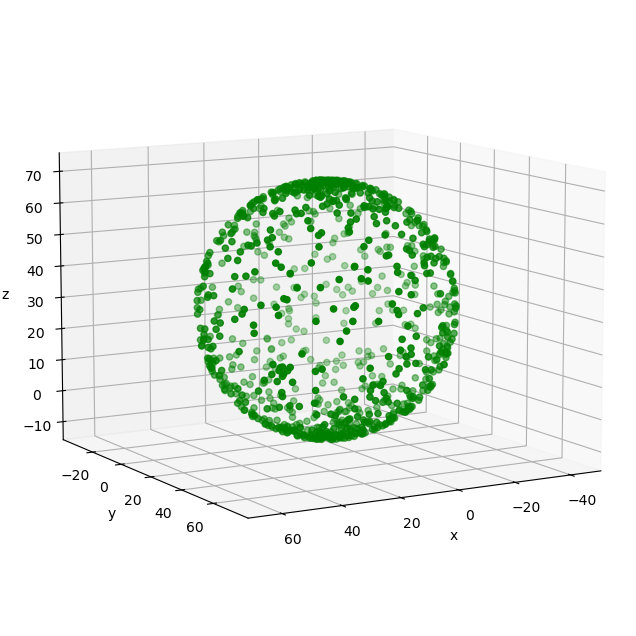

In [5]:
def generate_sphere(center, radius, n=1000):

    # Start with a unit sphere
    theta = np.random.uniform(0., np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    points = np.hstack((x, y, z))
    # Adjust radius
    points *= radius
    # Adjust position
    return points + center


# Create a sphere pointcloud
sphere_center = np.array([10., 20., 30.])
sphere_radius = 40.
points_sphere = generate_sphere(sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
           c="green",)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


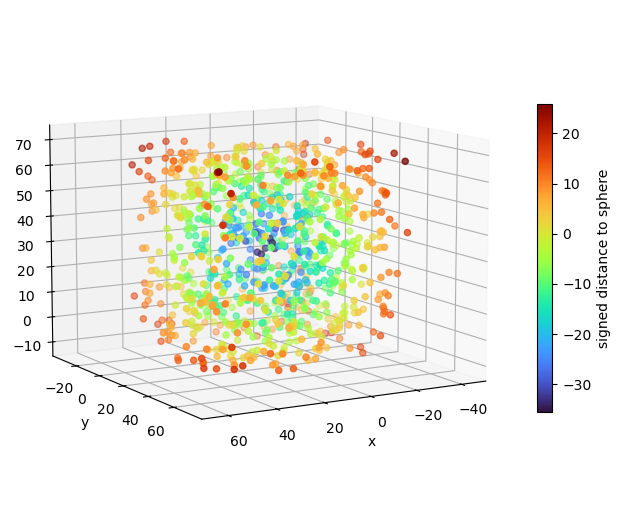

In [6]:
def dist_to_sphere(points, center, radius):
    """Signed distance to the sphere."""

    return np.linalg.norm(points - center, axis=1) - radius


# Try
random_points = np.random.uniform(points_sphere.min(axis=0), points_sphere.max(axis=0), (1000, 3))
dists_sphere = dist_to_sphere(random_points, sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_sphere, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to sphere')
plt.axis("equal")
plt.show()


In [7]:
def fit_sphere(points):

    # Coefficient matrix and values
    A = np.column_stack((2*points, np.ones(len(points))))
    b = (points**2).sum(axis=1)
    # Solve A x = b
    x, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # Sphere parameters
    center = x[:3]
    radius = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2 + x[3])
   
    return (center, radius), res


# Try
parameters, res = fit_sphere(points_sphere)

print("Fitted sphere parameters are:", parameters)
print("Residual is", res)


Fitted sphere parameters are: (array([10., 20., 30.]), 39.99999999999999)
Residual is [8.44561666e-22]


## Cylinder

### Parameters

| Parameter | Description |
|:----------|:------------|
| $c$       | center |
| $n$       | unit vector giving the direction of the axis |
| $r$       | radius |
| $l$       | length |


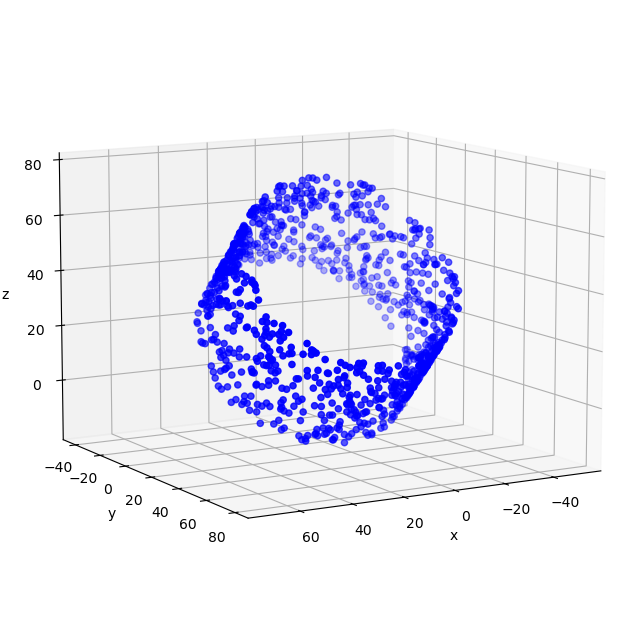

In [8]:
def generate_cylinder(center, normal, radius, length, n=1000):

    # Start with a unit cylinder pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.cos(theta)
    y = np.sin(theta)
    z = np.random.uniform(-0.5, 0.5, (n, 1))
    points = np.hstack((x, y, z))
    # Adjust radius and length
    points[:, :2] *= radius
    points[:, 2] *= length
    # Adjust orientation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust center
    return points + center


# Create a cylinder pointcloud
cylinder_center = np.array([10., 20, 30.])
cylinder_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cylinder_radius = 40.
cylinder_length = 50.
points_cylinder = generate_cylinder(cylinder_center, cylinder_normal, cylinder_radius, cylinder_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cylinder[:, 0], points_cylinder[:, 1], points_cylinder[:, 2],
           c="blue")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

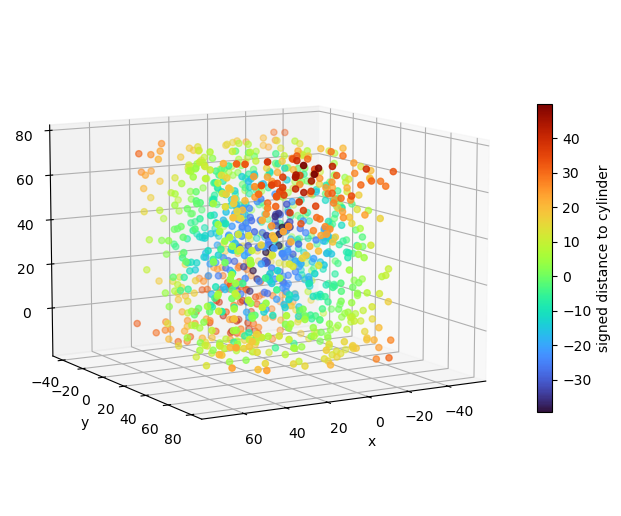

In [9]:
def dist_to_cylinder(points, center, normal, radius, length=None):
    """Signed distance to the cylinder"""

    # Distance to axis
    vec_to_center = points - center
    dist_to_axis = np.linalg.norm(np.cross(normal, vec_to_center), axis=1)
    # Distance to lateral surface
    d_r = dist_to_axis - radius
    if length is None:
        return d_r
    
    # If our cylinder is bounded (by two plane perpendicular to the axis)
    # there 3 cases to consider:
    d_t = np.zeros(len(d_r), dtype=float)
    # Projection on axis
    d_z = vec_to_center @ normal
    
    # 1. points that are "inside" the cylinder on z direction
    # (distance to lateral surface)
    inds_in = np.nonzero(np.abs(d_z) < length/2)[0]
    d_t[inds_in] = d_r[inds_in]
    
    # 2. points that are "outside" the cylinder on -z direction
    inds_out_1 = np.nonzero(d_z <= -length/2)[0]
    # Distance to end-circle
    c_1 = center - length/2 * normal
    vec_to_c_1 = points[inds_out_1] - c_1
    dist_to_axis_1 = np.linalg.norm(np.cross(normal, vec_to_c_1), axis=1)
    dist_to_circle_1 = np.sqrt((vec_to_c_1 @ normal)**2 + (dist_to_axis_1 - radius)**2)
    d_t[inds_out_1] = dist_to_circle_1
    
    # 3. Points "outside" the cylinder on +z direction
    inds_out_2 = np.nonzero(d_z >= length/2)[0]
    # Distance to end-circle
    c_2 = center + length/2 * normal
    vec_to_c_2 = points[inds_out_2] - c_2
    dist_to_axis_2 = np.linalg.norm(np.cross(normal, vec_to_c_2), axis=1)
    dist_to_circle_2 = np.sqrt((vec_to_c_2 @ normal)**2 + (dist_to_axis_2 - radius)**2)
    d_t[inds_out_2] = dist_to_circle_2
    
    return d_t


# Try
random_points = np.random.uniform(points_cylinder.min(axis=0), points_cylinder.max(axis=0), (1000, 3))
dists_cylinder = dist_to_cylinder(random_points, cylinder_center, cylinder_normal, cylinder_radius, cylinder_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_cylinder, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to cylinder')
plt.axis("equal")
plt.show()


In [10]:
def fit_cylinder(points):
    
    return


## Cone

### Parameters

| Parameter | Description |
|:----------|:------------|
| $c$       | apex position |
| $n$       | unit vector giving the direction of the axis |
| $\alpha$  | half-angle |
| $l$       | length |


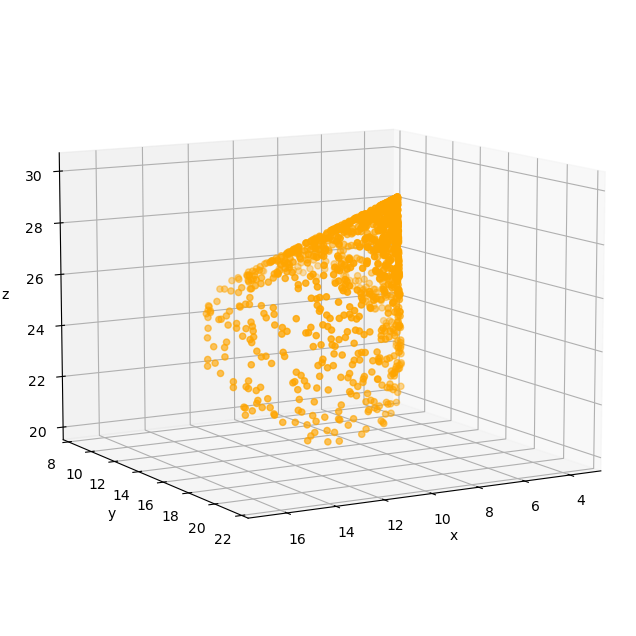

In [23]:
def generate_cone(apex, normal, half_angle, length, n=1000):
    """base radius of 1."""

    # Start with a cone of custom size pointing towards -z
    z = np.random.uniform(-length, 0., (n, 1))
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = z * np.tan(half_angle) * np.cos(theta)
    y = z * np.tan(half_angle) * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust rotation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust position (apex)
    return points + apex

# Generate a cone pointcloud
cone_apex = np.array([10., 20., 30.])
cone_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cone_half_angle = np.pi/8
cone_length = 10.
points_cone = generate_cone(cone_apex, cone_normal, cone_half_angle, cone_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cone[:, 0], points_cone[:, 1], points_cone[:, 2],
           c="orange")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


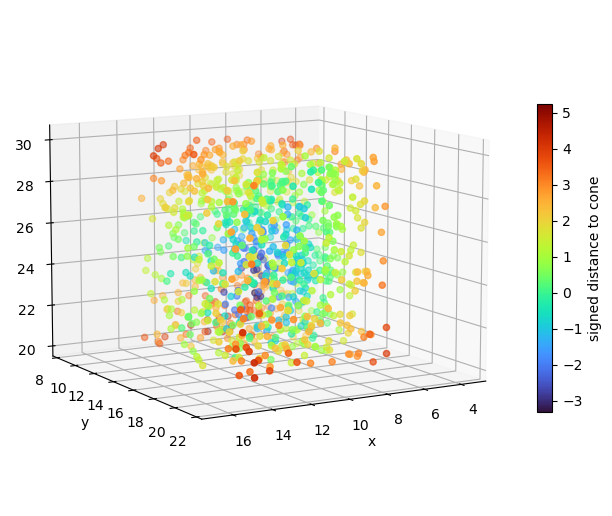

In [24]:
def dist_to_cone(points, apex, normal, half_angle, length=None):

    # Distance to axis
    vec_to_apex = points - apex
    dist_to_axis = np.linalg.norm(np.cross(normal, vec_to_apex), axis=1)
    # Projection on axis
    d_z = vec_to_apex @ normal
    # radius at z
    r_z = np.abs(d_z) * np.tan(half_angle)

    # For a semi-infinite cone there 2 cases to consider:
    d_t = np.zeros(len(points), dtype=float)
    
    # 1. points that are "inside" the cone on z direction
    # (distance to lateral surface)
    inds_in = np.nonzero(d_z < 0)[0]
    d_r = (dist_to_axis - r_z) * np.cos(half_angle)
    d_t[inds_in] = d_r[inds_in]

    # 2. points that are "outside" the cone on z direction
    # (distance to apex)
    inds_out_1 = np.nonzero(d_z >= 0)[0]
    d_t[inds_out_1] = np.linalg.norm(points[inds_out_1] - apex, axis=1)

    # and one more case to consider for a finite cone
    # 3. points that are "outside" the cone on -z direction
    # (distance to circle)
    if length is not None:
        inds_out_2 = np.nonzero(d_z <= -length)[0]
        # Circle size
        r_base = length * np.tan(half_angle)
        c_base = apex - length * normal
        # Distance to end-circle
        vec_to_c_2 = points[inds_out_2] - c_base
        dist_to_axis_2 = np.linalg.norm(np.cross(normal, vec_to_c_2), axis=1)
        dist_to_circle_2 = np.sqrt((vec_to_c_2 @ normal)**2 + (dist_to_axis_2 - r_base)**2)
        d_t[inds_out_2] = dist_to_circle_2

    return d_t

# Try
random_points = np.random.uniform(points_cone.min(axis=0), points_cone.max(axis=0), (1000, 3))
dists_cone = dist_to_cone(random_points, cone_apex, cone_normal, cone_half_angle, cone_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_cone, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to cone')
plt.axis("equal")
plt.show()


In [13]:
def fit_cone(points):
    
    return


## Torus

### Parameters

| Parameter | Description |
|:----------|:------------|
| $c$       | center |
| $n$       | unit vector giving the direction of the axis |
| $R$       | major radius |
| $r$       | minor radius |



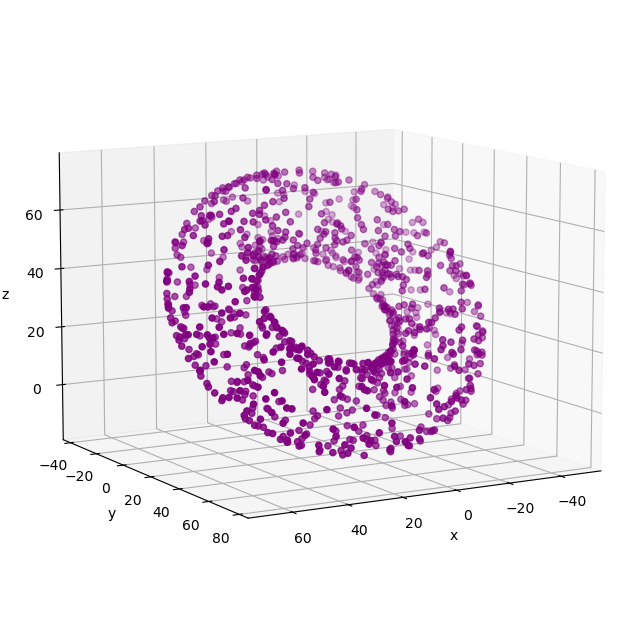

In [21]:
def generate_torus(center, normal, major_radius, minor_radius, n=1000):

    # Start with a torus of custom size pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = (major_radius+ minor_radius * np.cos(theta)) * np.cos(phi)
    y = (major_radius + minor_radius * np.cos(theta)) * np.sin(phi)
    z = minor_radius * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust orientation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust position
    return points + center

# Generate a torus pointcloud
torus_center = np.array([10., 20., 30.])
torus_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
torus_major_radius = 40
torus_minor_radius = 15.
points_torus = generate_torus(torus_center, torus_normal, torus_major_radius, torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_torus[:, 0], points_torus[:, 1], points_torus[:, 2],
           c="purple")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


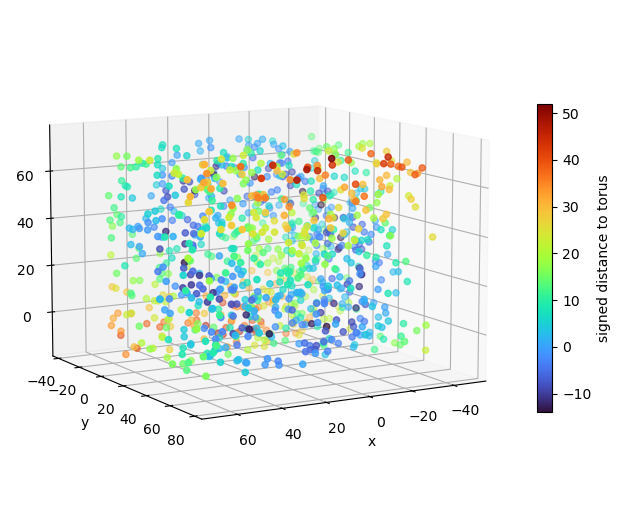

In [22]:
def dist_to_torus(points, center, normal, major_radius, minor_radius):

    vec_to_center = points - center
    
    s = np.linalg.norm(np.cross(normal, vec_to_center), axis=1)
    t = vec_to_center @ normal

    return np.sqrt(t**2 + (s - major_radius)**2) - minor_radius


# Try
random_points = np.random.uniform(points_torus.min(axis=0), points_torus.max(axis=0), (1000, 3))
dists_torus = dist_to_torus(random_points, torus_center, torus_normal, torus_major_radius, torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_torus, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to torus')
plt.axis("equal")
plt.show()


In [16]:
def fit_torus(points):
    
    return
